In [1]:
import sys
sys.path.append('..') 
import os

In [2]:
import pandas as pd
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta

## Data Loading

In [3]:
# # Save feature_engineered_df 
# feature_engineered_df.to_csv("data/feature_engineered_df.csv")
# # Load feature_engineered_df 
parse_dates = ["date"]
feature_engineered_df = pd.read_csv('data/feature_engineered_df.csv', index_col=[0], parse_dates=parse_dates)
feature_engineered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4698 entries, 15 to 5912
Data columns (total 18 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   date                                4698 non-null   datetime64[ns]
 1   province                            4698 non-null   object        
 2   current_month_consumption           4698 non-null   float64       
 3   last_year_same_month_consumption    4698 non-null   float64       
 4   last_year_total_consumption         4698 non-null   float64       
 5   current_month_share                 4698 non-null   float64       
 6   previous_1_month_share              4698 non-null   float64       
 7   previous_2_month_share              4698 non-null   float64       
 8   previous_3_month_share              4698 non-null   float64       
 9   previous_1_month_consumption        4698 non-null   float64       
 10  previous_2_month_consum

## Data Preperation

In [4]:
model_df = feature_engineered_df.sort_values(by=["date"]).reset_index(drop=True).copy()

In [5]:
# from src.model_selection.data_preperation import DataPreperation

# Initialize Data Preperation module
# dp = DataPreperation(data=model_df)
# # Train-Test split
# X_train, y_train, X_test, y_test = dp.tts_last_month(index_column1="date" ,index_column2="province")

# latter
# X_train, y_train, X_test, y_test, X_val, y_val = dp.ttvs_last_month(index_column1="date" ,index_column2="province",lag=lag, split_size = 0.05)
# print("Maximum date at val is: ", X_test.index.max(), " Shape is: ", X_val.shape)
# print("Minimum date at val is: ", X_test.index.min(), " Shape is: ", X_val.shape)  
# print("Maximum date at train is: ", X_train.index.max()," Shape is: ", X_train.shape)
# print("Minimum date at train is: ", X_train.index.min()," Shape is: ", X_train.shape)
# print("Maximum date at test is: ", X_test.index.max(), " Shape is: ", X_test.shape)
# print("Minimum date at test is: ", X_test.index.min(), " Shape is: ", X_test.shape)

## Model Selection

### Utils

#### Scoring

In [6]:
from typing import Any
import numpy as np
from sklearn.metrics import mean_squared_error 
def rmse(actual_value: Any, prediction: Any):
    return np.sqrt(((actual_value - prediction) ** 2)/2)

def ape(actual_value: Any, prediction: Any):
    return abs(actual_value-prediction)/actual_value*100
     
def prep_scoring_df(X_test: pd.DataFrame, y_test: pd.DataFrame, target_col: str="current_month_consumption", col_list: list=None)-> pd.DataFrame:
    scoring_df = X_test.copy()
    scoring_df["actual_value"] = y_test[target_col]
    scoring_df.reset_index(level="province",inplace=True)
    if not col_list:
        col_list = ["province", "actual_value"]
    scoring_df = scoring_df[col_list]
    return scoring_df

def scoring(X_test: pd.DataFrame, y_test: pd.DataFrame, scoring_df: pd.DataFrame, predictions: Any, model_name: str="XGB")-> pd.DataFrame:
    if scoring_df.empty:
        scoring_df = prep_scoring_df(X_test=X_test, y_test=y_test)
    else: 
        scoring_df = scoring_df.copy()
    # Insert predictions
    scoring_df[f"{model_name}_prediction"] = predictions
    # Add rmse
    scoring_df[f"{model_name}_rmse"] = scoring_df.apply(lambda row: rmse(row.actual_value, row[f"{model_name}_prediction"]), axis=1)
    # Add percentage difference
    scoring_df[f"{model_name}_absolute_percent_error"] = scoring_df.apply(lambda row: ape(row.actual_value, row[f"{model_name}_prediction"]), axis=1)
    
    print("Number of records greater than 20 percent error:",(scoring_df[f"{model_name}_absolute_percent_error"] > 20).sum())
    print("Number of records greater than 15 percent error:",(scoring_df[f"{model_name}_absolute_percent_error"] > 15).sum())
    print("Number of records greater than 10 percent error:",(scoring_df[f"{model_name}_absolute_percent_error"] > 10).sum())
    print("Number of records greater than 5 percent error:",(scoring_df[f"{model_name}_absolute_percent_error"] > 5).sum())
    return scoring_df

### XGB

In [7]:
# Initialization parameters
init_params = {
    # "early_stopping_rounds": 20,
    # "eval_metric": ["rmsle","mape","rmse"] # default ,mae(kötü) ,mape(kötü), rmse, rmsle(1 tane 54 gerisi 20nin altında), 
}
grid_search_params = {
    'alpha': [0.0075, 0.015],    
    'colsample_bytree': [0.5, 1.0],
    'learning_rate': [0.045, 0.050],    
    'max_depth': [7, 8],
    'min_child_weight': [1, 2, 3],
    'n_estimators': [900, 1000],
    'subsample': [0.5, 1],
}
fit_params = {}

In [9]:
from src.model_selection.data_preperation import DataPreperation
from src.model_selection.modelling import xgb_simulator
scoring_df=pd.DataFrame()
for lag in range(3):
    print("Run for Lag=", lag)
    # Train test split
    dp = DataPreperation(data=model_df)
    X_train, y_train, X_test, y_test = dp.tts_last_month(index_column1="date" ,index_column2="province", lag=lag)

    # Initialize Simulator
    xgb = xgb_simulator(init_params=init_params, fit_params=fit_params, 
                        grid_search_params=grid_search_params, save=False)
    
    # Train the model
    xgb(X_train=X_train, y_train=y_train)
    # Set the best_model and best_parameter
    best_model = xgb.best_model
    best_params = xgb.best_params
    print(f"Best Parameters when lag = {lag}",best_params)
    # Predict test set
    predictons = best_model.predict(X_test)
    # Log results
    
    scoring_df = scoring(X_test=X_test, y_test=y_test, predictions=predictons, scoring_df=scoring_df, model_name=f"Lag_{lag}_XGB")    


Run for Lag= 0
Fitting 5 folds for each of 192 candidates, totalling 960 fits
Save is:  True
Best Parameters when lag = 0 {'alpha': 0.015, 'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 1000, 'subsample': 0.5}
Number of records greater than 20 percent error: 5
Number of records greater than 15 percent error: 9
Number of records greater than 10 percent error: 12
Number of records greater than 5 percent error: 33
Run for Lag= 1
Fitting 5 folds for each of 192 candidates, totalling 960 fits


In [ ]:
"""With cv = timseries.split"""
# Run for Lag= 0
# Fitting 5 folds for each of 1800 candidates, totalling 9000 fits
# Best Parameters when lag = 0 {'alpha': 0.015, 'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 1000, 'subsample': 0.5}
# Number of records greater than 20 percent error: 5
# Number of records greater than 15 percent error: 9
# Number of records greater than 10 percent error: 12
# Number of records greater than 5 percent error: 33
# Run for Lag= 1
# Fitting 5 folds for each of 1800 candidates, totalling 9000 fits
# Best Parameters when lag = 1 {'alpha': 0.0075, 'colsample_bytree': 1.0, 'learning_rate': 0.045, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 1000, 'subsample': 0.5}
# Number of records greater than 20 percent error: 1
# Number of records greater than 15 percent error: 1
# Number of records greater than 10 percent error: 2
# Number of records greater than 5 percent error: 4
# Run for Lag= 2
# Fitting 5 folds for each of 1800 candidates, totalling 9000 fits
# Best Parameters when lag = 2 {'alpha': 0.0075, 'colsample_bytree': 1.0, 'learning_rate': 0.045, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 1000, 'subsample': 0.5}
# Number of records greater than 20 percent error: 0
# Number of records greater than 15 percent error: 0
# Number of records greater than 10 percent error: 0
# Number of records greater than 5 percent error: 4

'With cv = timseries.split'

In [ ]:
scoring_df.head()

,province,actual_value,Lag_2_XGB__prediction,Lag_2_XGB__rmse,Lag_2_XGB__absolute_percent_error
date,,,,,
2021-11-01,ADANA,51866.171,51237.566406,444.490571,1.211974
2021-11-01,ADIYAMAN,14484.578,14645.775391,113.983768,1.112890
2021-11-01,AFYONKARAHİSAR,24347.612,24946.062500,423.168407,2.457943
2021-11-01,AKSARAY,15854.929,15866.357422,8.081115,0.072081
2021-11-01,AMASYA,14261.144,14184.955078,53.873703,0.534241


Shape of dataframe is :  (81, 5)


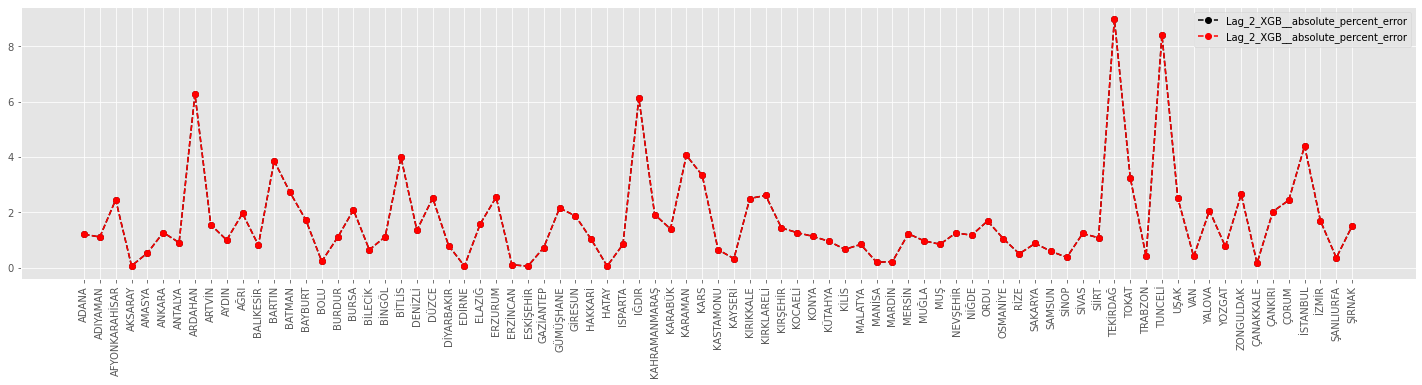

In [ ]:
from src.utils.plotting import plot_metrics
plot_metrics(scoring_df, col_x="province", col_y1="Lag_1_XGB__absolute_percent_error", col_y2="Lag_2_XGB__absolute_percent_error")

### ARIMA

In [ ]:
# load preprocessed data
parse_dates = ["date"]
preprocessed_df = pd.read_csv('data/preprocessed_df.csv', index_col=[0], parse_dates=parse_dates)
preprocessed_df.info()

In [ ]:
# We should decide on p, d, q

In [ ]:
"""Selec p Value"""

In [ ]:
"""Select d Value"""
# Apply Stationary test and Choose the d value where p < 0.05
from statsmodel.tsa.stattools import adfuller

result = adfuller(preprocessed_df.current_month_consumption)
print("p-value: ", result[1])

result = adfuller(preprocessed_df.current_month_consumption.diff())
print("p-value: ", result[1])

result = adfuller(preprocessed_df.current_month_consumption.diff().diff())
print("p-value: ", result[1])

In [ ]:
"""Select q Value"""